![Einflussfaktoren auf Strompreis](https://blog.enviam.de/wp-content/uploads/2022/01/infografik_einflussfaktoren-auf-strompreis-1.jpg)


## ToDo:

- [ ] CO_2 Preise hinzufügen
- [ ] Gaspreise hinzufügen
- [ ] Rohölpreise hinzufügen
- [ ] Kohlepreise hinzufügen
- [ ] Verbraucherverhalten hinzufügen (Jahreszeit, is_ferien_ja/nein)
- [ ] Wir nutzen viel Gas in Deutschland, also auch Füllstand? 

In [2]:
import sys
import os

In [3]:
# Add the absolute path to the `iTransformer/model` directory at the start of sys.path
sys.path.insert(0, os.path.abspath("iTransformer"))

In [5]:
import torch
import numpy as np
from iTransformer.model.iTransformer import Model

/Users/sebastianeggers/anaconda3/envs/data-lineage/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Define configuration settings
class Configs:
    def __init__(self):
        self.seq_len = 30          # Input sequence length (e.g., 30 days)
        self.pred_len = 7          # Prediction length (e.g., forecast next 7 days)
        self.d_model = 64          # Dimension of the model
        self.embed = 'timeF'       # Embedding type for time features
        self.freq = 'd'            # Daily frequency for electricity data
        self.dropout = 0.1         # Dropout rate
        self.e_layers = 2          # Number of encoder layers
        self.n_heads = 4           # Number of attention heads
        self.d_ff = 128            # Feedforward dimension
        self.activation = 'relu'   # Activation function
        self.output_attention = False
        self.use_norm = True
        self.class_strategy = None # Additional class settings (adjust as needed)
        self.factor = 5            # Scaling factor for attention (set according to model needs)


configs = Configs()

# Instantiate the model
model = Model(configs)

In [7]:
# Dummy data preparation (replace with actual electricity price data)
batch_size = 1
n_features = 1  # For univariate data (single electricity price series)

In [8]:
# Create dummy data for input and timestamp embeddings
x_enc = torch.rand(batch_size, configs.seq_len, n_features)  # Encoder input
x_mark_enc = torch.rand(batch_size, configs.seq_len, n_features)  # Encoder timestamps
x_dec = torch.rand(batch_size, configs.pred_len, n_features)  # Decoder input
x_mark_dec = torch.rand(batch_size, configs.pred_len, n_features)  # Decoder timestamps

In [9]:
# Perform forecasting
model.eval()  # Set model to evaluation mode for inference
with torch.no_grad():
    output = model(x_enc, x_mark_enc, x_dec, x_mark_dec)

# Display forecasted values
print("Forecasted electricity prices:", output.squeeze().numpy())

Forecasted electricity prices: [0.49446467 0.5079422  0.54511225 0.66806185 0.7017226  0.5635793
 0.43076253]


In [10]:
# Lets try to fit a iTransformer on my data

In [12]:
import pandas as pd

# Load the data
file_path = 'time_series_jan_feb.xlsx'
df = pd.read_excel(file_path)

# Check the data structure
print(df.head())

             start_date             end_date  Germany/Luxembourg [€/MWh]
0  Jan 1, 2024 12:00 AM  Jan 1, 2024 1:00 AM                        0.10
1   Jan 1, 2024 1:00 AM  Jan 1, 2024 2:00 AM                        0.01
2   Jan 1, 2024 2:00 AM  Jan 1, 2024 3:00 AM                        0.00
3   Jan 1, 2024 3:00 AM  Jan 1, 2024 4:00 AM                       -0.01
4   Jan 1, 2024 4:00 AM  Jan 1, 2024 5:00 AM                       -0.03


In [13]:
# Assuming 'timestamp' is the time column and 'price' is the target
df['start_date'] = pd.to_datetime(df['start_date'])
df = df.sort_values(by='start_date').reset_index(drop=True)

# Extract just the hourly price data for simplicity
prices = df['Germany/Luxembourg [€/MWh]'].values

/var/folders/41/1kj78bhs1gb4jx_9sml7q10h0000gn/T/ipykernel_40008/87859670.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])


In [14]:
import torch
import numpy as np

# Define sequences for the model
seq_len = 24  # Input sequence length (last 24 hours)
pred_len = 24  # Forecast length (next 24 hours)

In [15]:
# Create sequences of input and output pairs
x_data = []
y_data = []
for i in range(len(prices) - seq_len - pred_len):
    x = prices[i:i + seq_len]
    y = prices[i + seq_len:i + seq_len + pred_len]
    x_data.append(x)
    y_data.append(y)

In [16]:
# Convert to numpy arrays and then to tensors
x_data = np.array(x_data)
y_data = np.array(y_data)

In [17]:
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

In [18]:
# Reshape to match model requirements: [batch_size, seq_len, n_features]
x_data = x_data.unsqueeze(-1)  # Add a features dimension for univariate
y_data = y_data.unsqueeze(-1)

In [19]:
import sys
import os

In [20]:
# Add the absolute path to the `iTransformer/model` directory at the start of sys.path
sys.path.insert(0, os.path.abspath("iTransformer"))

In [21]:
from torch.utils.data import DataLoader, TensorDataset
from iTransformer.model.iTransformer import Model

In [22]:
# Define configuration settings
class Configs:
    def __init__(self):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.d_model = 64
        self.embed = 'timeF'
        self.freq = 'h'            # Hourly frequency for data
        self.dropout = 0.1
        self.e_layers = 2
        self.n_heads = 4
        self.d_ff = 128
        self.activation = 'relu'
        self.output_attention = False
        self.use_norm = True
        self.class_strategy = None
        self.factor = 5

In [23]:
configs = Configs()
model = Model(configs)

In [24]:
# Create DataLoader for batching
batch_size = 16
train_dataset = TensorDataset(x_data, y_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [25]:
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
# Training loop
model.train()
epochs = 10
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        # Forecast
        output = model(x_batch, None, None, None)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 328.6707
Epoch 2/10, Loss: 374.9592
Epoch 3/10, Loss: 404.3794
Epoch 4/10, Loss: 464.3424
Epoch 5/10, Loss: 348.1756
Epoch 6/10, Loss: 432.3201
Epoch 7/10, Loss: 276.9541
Epoch 8/10, Loss: 369.9038
Epoch 9/10, Loss: 380.7959
Epoch 10/10, Loss: 398.6284


In [27]:
# Inference example (predict the next 24 hours)
model.eval()
with torch.no_grad():
    last_24_hours = torch.tensor(prices[-seq_len:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    predicted_prices = model(last_24_hours, None, None, None)
    print("Predicted prices for the next 24 hours:", predicted_prices.squeeze().numpy())

Predicted prices for the next 24 hours: [63.59449  61.968845 60.274246 58.26671  59.36861  63.507824 69.25498
 76.623695 81.356026 81.486206 79.28602  74.18601  72.267784 71.787704
 73.192375 79.68284  84.868744 88.07748  88.62962  85.13358  79.09833
 75.07233  71.78216  67.58218 ]


In [28]:
# Load the validation data (assuming it’s in the same file for simplicity)
file_path = 'validation_dataset.xlsx'
validation_df = pd.read_excel(file_path)  # Adjust the sheet name if needed
validation_df['start_date'] = pd.to_datetime(validation_df['start_date'])
validation_df = validation_df.sort_values(by='start_date').reset_index(drop=True)
validation_prices = validation_df['Germany/Luxembourg [€/MWh]'].values

/var/folders/41/1kj78bhs1gb4jx_9sml7q10h0000gn/T/ipykernel_40008/3100871089.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  validation_df['start_date'] = pd.to_datetime(validation_df['start_date'])


In [29]:
# Prepare the validation input sequence (last 24 hours for input)
validation_input = validation_prices[:seq_len]  # Assuming we start with the initial sequence for forecasting

In [30]:
validation_input

array([60.63, 59.34, 55.76, 54.79, 55.06, 58.43, 63.23, 72.74, 79.73,
       69.65, 63.86, 63.29, 62.63, 63.82, 69.03, 72.23, 78.54, 82.97,
       87.58, 84.47, 76.48, 69.68, 68.2 , 63.8 ])

In [31]:
validation_input = torch.tensor(validation_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

In [32]:
actual_values = np.array(validation_input).flatten()

In [33]:
len(actual_values)

24

In [34]:
predicted_values = np.array(predicted_prices).flatten()

In [35]:
len(predicted_values)

24

In [36]:
import matplotlib.pyplot as plt

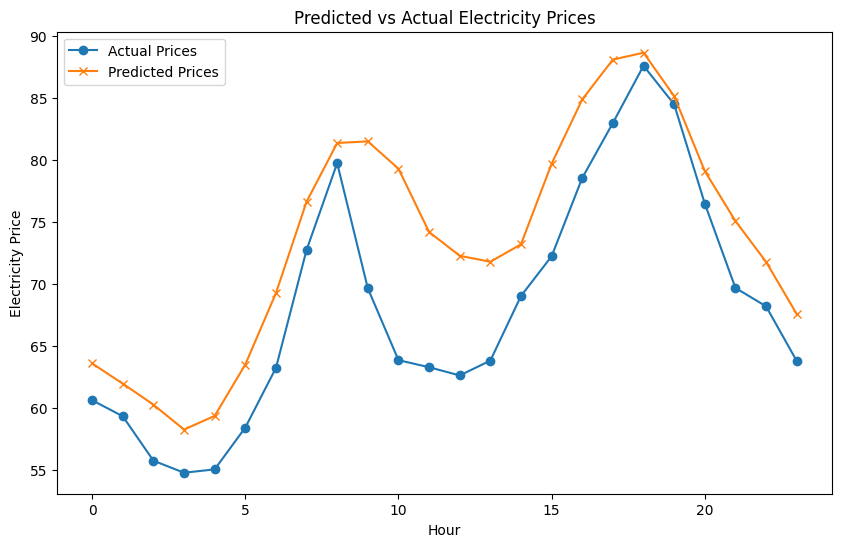

In [37]:
# Plot the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_values)), actual_values, label="Actual Prices", marker='o')
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Prices", marker='x')
plt.xlabel("Hour")
plt.ylabel("Electricity Price")
plt.title("Predicted vs Actual Electricity Prices")
plt.legend()
plt.show()